<a href="https://www.kaggle.com/code/odiradancan/carsalesprediction-random-forest-regression?scriptVersionId=112567451" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ann-car-sales-price-prediction/car_purchasing.csv


### 1. Importing module dependencies

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

### 2. Loading the dataset

In [3]:

car_sales = pd.read_csv('/kaggle/input/ann-car-sales-price-prediction/car_purchasing.csv', encoding = 'latin-1')
car_sales.head()

,customer name,customer e-mail,country,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


### 3. Data preprocessing

In [4]:
car_sales.describe()

,gender,age,annual Salary,credit card debt,net worth,car purchase amount
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.506000,46.241674,62127.239608,9607.645049,431475.713625,44209.799218
std,0.500465,7.978862,11703.378228,3489.187973,173536.756340,10773.178744
min,0.000000,20.000000,20000.000000,100.000000,20000.000000,9000.000000
25%,0.000000,40.949969,54391.977195,7397.515792,299824.195900,37629.896040
50%,1.000000,46.049901,62915.497035,9655.035568,426750.120650,43997.783390
75%,1.000000,51.612263,70117.862005,11798.867487,557324.478725,51254.709517
max,1.000000,70.000000,100000.000000,20000.000000,1000000.000000,80000.000000


In [5]:
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer name        500 non-null    object 
 1   customer e-mail      500 non-null    object 
 2   country              500 non-null    object 
 3   gender               500 non-null    int64  
 4   age                  500 non-null    float64
 5   annual Salary        500 non-null    float64
 6   credit card debt     500 non-null    float64
 7   net worth            500 non-null    float64
 8   car purchase amount  500 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 35.3+ KB


In [6]:
# identifying variables that are closely correlated to the dependent variable(carpurchase amount)
car_sales.corr()

,gender,age,annual Salary,credit card debt,net worth,car purchase amount
gender,1.000000,-0.064481,-0.036499,0.024193,-0.008395,-0.066408
age,-0.064481,1.000000,0.000130,0.034721,0.020356,0.632865
annual Salary,-0.036499,0.000130,1.000000,0.049599,0.014767,0.617862
credit card debt,0.024193,0.034721,0.049599,1.000000,-0.049378,0.028882
net worth,-0.008395,0.020356,0.014767,-0.049378,1.000000,0.488580
car purchase amount,-0.066408,0.632865,0.617862,0.028882,0.488580,1.000000


In [7]:
car_sales.country.unique()

array(['Bulgaria', 'Belize', 'Algeria', 'Cook Islands', 'Brazil',
       'Liberia', 'Syria', 'Czech Republic', 'Armenia', 'Somalia',
       'Sint Maarten', 'Greenland', 'Nicaragua', 'Palestine, State of',
       'United Arab Emirates', 'Gabon', 'Tokelau', 'Portugal', 'Chad',
       'Iraq', 'Sudan', 'Angola', 'Nigeria', 'Madagascar', 'Macedonia',
       'Oman', 'Colombia', 'Namibia', 'Denmark', 'Dominican Republic',
       'Costa Rica', 'Botswana', 'Saint Pierre and Miquelon', 'France',
       'Senegal', 'Cambodia', 'Suriname', 'Turkey', 'Ethiopia',
       'French Guiana', 'Bhutan', 'Georgia', 'Mozambique', 'Nauru',
       'Timor-Leste', 'Djibouti', 'Argentina', 'Taiwan', 'Åland Islands',
       'Turks and Caicos Islands', 'Samoa', 'Vanuatu', 'Mongolia',
       'Sri Lanka', 'Guinea-Bissau', 'Egypt', 'Slovenia', 'Benin',
       'Cape Verde', 'Paraguay', 'Laos', 'Iceland', 'Viet Nam',
       'Marshall Islands', 'Germany', 'Kyrgyzstan', 'Mauritius', 'Gambia',
       'Reunion', 'Jordan', 'S

In [8]:
car_sales = car_sales.drop(columns = ['customer name', 'customer e-mail', 'country'], axis=1)
car_sales.head()

,gender,age,annual Salary,credit card debt,net worth,car purchase amount
0,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248


<AxesSubplot:xlabel='annual Salary', ylabel='car purchase amount'>

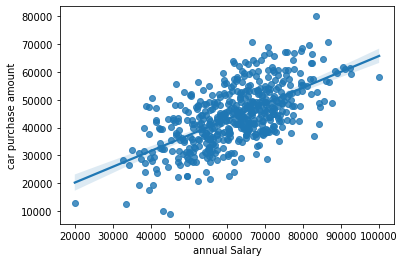

In [9]:
sns.regplot(x = 'annual Salary', y = 'car purchase amount', data = car_sales)

Annual Salary against car purchase amount exhibits linearity

<AxesSubplot:xlabel='credit card debt', ylabel='car purchase amount'>

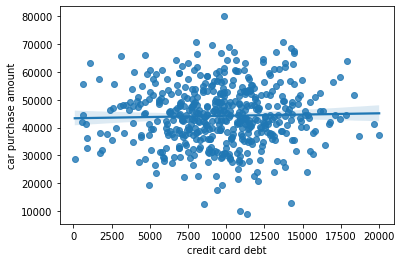

In [10]:
sns.regplot(x = 'credit card debt', y = 'car purchase amount', data = car_sales)

credit card debt exhibits very minimal linearity to car purchase amount 

<AxesSubplot:xlabel='age', ylabel='car purchase amount'>

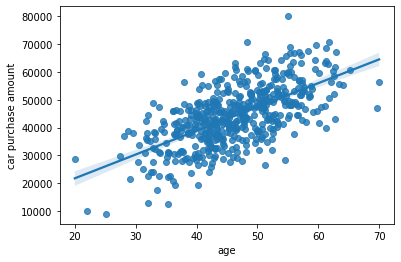

In [11]:
sns.regplot(x = 'age', y = 'car purchase amount', data = car_sales)

Age exhibits linearity to the car purchase amount 

<AxesSubplot:xlabel='net worth', ylabel='car purchase amount'>

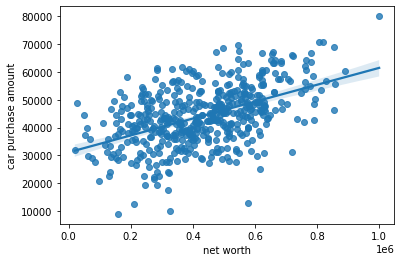

In [12]:
sns.regplot(x = 'net worth', y = 'car purchase amount', data = car_sales)

net worth of a client exhibits linearity

### 4. Splitting and fitting the dataset

In [13]:
X = car_sales.iloc[:,:-1].values
y = car_sales.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)
regF = RandomForestRegressor()
regF.fit(X_train, y_train)

RandomForestRegressor()

### 5. Predicting y vals

In [14]:
y_pred = regF.predict(X_test)

In [15]:
df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df.head()

,Actual,Predicted
0,38930.55234,39204.253659
1,47979.48549,46964.546691
2,46937.17422,48505.287597
3,50188.86612,50120.903939
4,40095.04980,40676.494263


In [16]:
regF.score(X_train, y_train)

0.9910879583480907

### 6.Visualization

<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

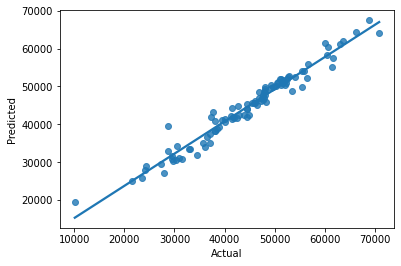

In [17]:
sns.regplot(data = df, x = 'Actual', y = 'Predicted', ci = False)

### 7: Error Analysis

In [18]:
print(f'MSE:{mean_squared_error(y_test, y_pred)}')
print(f'MAE:{mean_absolute_error(y_test, y_pred)}')
print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_pred))}')

MSE:6442883.745607559
MAE:1643.157686253999
RMSE:2538.2836219791434


The model has an accuracy of 99% and a mean absolute error of 1774.145

<b>Being that the credit card debt feature did not show much correlation with the car purchase amount, let's run a model that excludes the feature.

In [19]:
car_sales = car_sales.drop(columns = ['credit card debt'])

In [20]:
car_sales.head()

,gender,age,annual Salary,net worth,car purchase amount
0,0,41.851720,62812.09301,238961.2505,35321.45877
1,0,40.870623,66646.89292,530973.9078,45115.52566
2,1,43.152897,53798.55112,638467.1773,42925.70921
3,1,58.271369,79370.03798,548599.0524,67422.36313
4,1,57.313749,59729.15130,560304.0671,55915.46248


In [21]:
regF2 = RandomForestRegressor()
X = car_sales.iloc[:,:-1].values
y = car_sales.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)
regF2.fit(X_train, y_train)
y_pred2 = regF2.predict(X_test)
df2 = pd.DataFrame({'Actual_vals': y_test, 'Predicted_vals': y_pred})
df2.head()

,Actual_vals,Predicted_vals
0,66158.69494,39204.253659
1,44434.98419,46964.546691
2,30841.00154,48505.287597
3,47693.23482,50120.903939
4,42704.32210,40676.494263


In [22]:
regF2.score(X_train, y_train)

0.9930872257496027

In [23]:
regF2.score(X_train, y_train)

0.9930872257496027

In [24]:
diff = (0.9916834598232228 - 0.9911537068061526) *100
diff

0.05297530170702558

There is a 0.053% better prediction in the model without the credit card debt
